# Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import pathlib

In [2]:
#seeding
seed = 2021
np.random.seed = seed
tf.seed = seed

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maksahu","key":"cff8c0f086aa6e0e50553f7ab0580687"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Data

In [5]:
!kaggle competitions download -c data-science-bowl-2018

  0% 0.00/9.10M [00:00<?, ?B/s]
100% 9.10M/9.10M [00:00<00:00, 83.2MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 95.2MB/s]
 99% 274M/276M [00:02<00:00, 143MB/s]
100% 276M/276M [00:02<00:00, 130MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 118MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 306kB/s]
 95% 75.0M/79.1M [00:00<00:00, 85.9MB/s]
100% 79.1M/79.1M [00:00<00:00, 95.0MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 88.3MB/s]


In [6]:
#Creating these two folder
!mkdir train test

In [7]:
#Unziping the training and testing folders into directories
print('Unzipping stage1_train.zip')
!unzip -q "/content/stage1_train.zip" -d train/
print('Unzipped stage1_train.zip')

print('Unzipping stage1_test.zip')
!unzip -q "/content/stage1_train.zip" -d test/
print('Unzipped stage1_test.zip')

Unzipping stage1_train.zip
Unzipped stage1_train.zip
Unzipping stage1_test.zip
Unzipped stage1_test.zip


In [8]:
# Root directories for training and testing
TRAIN_ROOT = './train'
TEST_ROOT = './test'

In [9]:
# Function to create a dataframe of files which will be used for further processing
def files_df(root_dir):
    subdir = os.listdir(root_dir)
    files = []
    df = pd.DataFrame()
    for dir in subdir:
        files.append(os.path.join(root_dir,dir))
    df['files'] = files
    return df

In [10]:
train_df = files_df(TRAIN_ROOT)
test_df = files_df(TEST_ROOT)

In [11]:
# Hyperparameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
CLASSES = 1
BATCH_SIZE = 8

In [12]:
# Function which will create a dataframe of image paths and mask paths along with creating a single mask with multiple masks
def image_df(filenames):
    image_paths = []
    mask_paths = []
    df = pd.DataFrame()
    for filename in tqdm(filenames):
        file_path = os.path.join(filename,'images')
        image_path = os.path.join(file_path,os.listdir(file_path)[0])
        image_paths.append(image_path)
        
        mask = np.zeros((IMG_WIDTH,IMG_HEIGHT,CLASSES))
        mask_dir = file_path.replace("images", "masks")
        masks = os.listdir(mask_dir)
        for m in masks:
            mask_path = os.path.join(mask_dir,m)
            mask_  = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            mask_  = cv2.resize(mask_,(IMG_WIDTH,IMG_HEIGHT),interpolation=cv2.INTER_NEAREST)
            mask_  = np.expand_dims(mask_, axis = -1)
            mask = np.maximum(mask,mask_)
        newmask_dir = mask_dir.replace("masks", "masks_")
        if not os.path.isdir(newmask_dir):
            os.mkdir(newmask_dir)
        newmask_path = image_path.replace("images", "masks_")
        mask_paths.append(newmask_path)
        cv2.imwrite(newmask_path, mask)
    df['images'] = image_paths
    df['masks'] = mask_paths
    return df

In [13]:
# Training dataframe
train_filenames = train_df['files']
train = image_df(train_filenames)

100%|██████████| 670/670 [00:33<00:00, 20.20it/s]


In [14]:
train.head()

,images,masks
0,./train/4e07a653352b30bb95b60ebc6c57afbc721571...,./train/4e07a653352b30bb95b60ebc6c57afbc721571...
1,./train/ce88df7356d9d4a8d5944a93768f4c4b593de2...,./train/ce88df7356d9d4a8d5944a93768f4c4b593de2...
2,./train/bff985591dd5d6303018a6e9a3dcfb336771a4...,./train/bff985591dd5d6303018a6e9a3dcfb336771a4...
3,./train/ff599c7301daa1f783924ac8cbe3ce7b42878f...,./train/ff599c7301daa1f783924ac8cbe3ce7b42878f...
4,./train/54cb3328e778d87f76062b0550e3bc190f4638...,./train/54cb3328e778d87f76062b0550e3bc190f4638...


# Models

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tflite_models_dir = pathlib.Path("/content/drive/MyDrive/CaseStudy2/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [16]:
# UNet Model
unet_model = tf.keras.models.load_model("/content/drive/MyDrive/CaseStudy2/unet_model.h5")

In [ ]:
# Post Training quantized UNet model
converter = tf.lite.TFLiteConverter.from_keras_model(unet_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_unet_model = converter.convert()
# Save the quantized UNet model:
quant_unet_file = tflite_models_dir/"quant_unet_model.tflite"
quant_unet_file.write_bytes(quant_unet_model)

INFO:tensorflow:Assets written to: /tmp/tmpl1mqrezn/assets


In [17]:
# HRNet Model
hrnet_model = tf.keras.models.load_model("/content/drive/MyDrive/CaseStudy2/hrnet_model.h5")

In [ ]:
# Post Training quantized HRNet model
converter = tf.lite.TFLiteConverter.from_keras_model(hrnet_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_hrnet_model = converter.convert()
# Save the quantized HRNet model:
quant_hrnet_file = tflite_models_dir/"quant_hrnet_model.tflite"
quant_hrnet_file.write_bytes(quant_hrnet_model)

29361344

## Sizes of Models before and after quantization

In [30]:
print("UNet model in Mb:", os.path.getsize("/content/drive/MyDrive/CaseStudy2/unet_model.h5") / float(2**20))
print("Quantized UNet in Mb:", os.path.getsize("/content/drive/MyDrive/CaseStudy2/quant_unet_model.tflite") / float(2**20))
print("Float HRNet in Mb:", os.path.getsize("/content/drive/MyDrive/CaseStudy2/hrnet_model.h5") / float(2**20))
print("Quantized HRNet in Mb:", os.path.getsize("/content/drive/MyDrive/CaseStudy2/quant_hrnet_model.tflite") / float(2**20))

UNet model in Mb: 22.430435180664062
Quantized UNet in Mb: 1.903717041015625
Float HRNet in Mb: 331.6315689086914
Quantized HRNet in Mb: 28.00115966796875


- We can see the considerable decrease in the file sizes of both the UNet and HRNet models.
- This reduction is good when we want to deploy our models on small devices.

# EDA

In [18]:
# Custom MeanIoU Metric function
class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, thres=0.5, name='mean_iou', dtype=None):
        super(MeanIoU, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.thres = thres
        self.total_cm = self.add_weight('total_confusion_matrix',
                                        shape=(num_classes, num_classes),
                                        initializer=tf.zeros_initializer())

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        y_true = tf.cast(y_true, self._dtype)
        y_pred = tf.cast(y_pred, self._dtype)
        if y_pred.shape.ndims > 1:
            y_pred = tf.reshape(y_pred, [-1])
        if y_true.shape.ndims > 1:
            y_true = tf.reshape(y_true, [-1])
        
        y_pred = tf.where(y_pred > self.thres, 1.0, 0.0)
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self._dtype)
            if sample_weight.shape.ndims > 1:
                sample_weight = tf.reshape(sample_weight, [-1])
        current_cm = tf.math.confusion_matrix(y_true,
                                              y_pred,
                                              self.num_classes,
                                              weights=sample_weight,
                                              dtype=self._dtype)
        
        return self.total_cm.assign_add(current_cm)

    def result(self):
        sum_over_row = tf.cast(tf.reduce_sum(self.total_cm, axis=0), dtype=self._dtype)
        sum_over_col = tf.cast(tf.reduce_sum(self.total_cm, axis=1), dtype=self._dtype)
        true_positives = tf.cast(tf.linalg.tensor_diag_part(self.total_cm), dtype=self._dtype)
        denominator = sum_over_row + sum_over_col - true_positives
        num_valid_entries = tf.reduce_sum(tf.cast(tf.math.not_equal(denominator, 0), dtype=self._dtype))
        iou = tf.math.divide_no_nan(true_positives, denominator)
        return tf.math.divide_no_nan(tf.reduce_sum(iou, name='mean_iou'), num_valid_entries)
    
    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        tf.keras.backend.set_value(self.total_cm, np.zeros((self.num_classes, self.num_classes)))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(MeanIoU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [19]:
# Importing Quantized UNet model
u_interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/CaseStudy2/quant_unet_model.tflite")
# Function to predict segments using quantized UNet model
def lite_unet_model(images):
  u_interpreter.allocate_tensors()
  u_interpreter.set_tensor(u_interpreter.get_input_details()[0]['index'], images)
  u_interpreter.invoke()
  return u_interpreter.get_tensor(u_interpreter.get_output_details()[0]['index'])

In [20]:
# Importing Quantized HRNet model
h_interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/CaseStudy2/quant_hrnet_model.tflite")
# Function to predict segments using quantized HRNet model
def lite_hrnet_model(images):
  h_interpreter.allocate_tensors()
  h_interpreter.set_tensor(h_interpreter.get_input_details()[0]['index'], images)
  h_interpreter.invoke()
  return h_interpreter.get_tensor(h_interpreter.get_output_details()[0]['index'])

## Sample Predictions of all the models

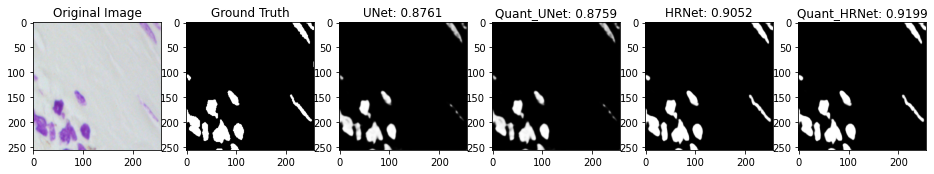

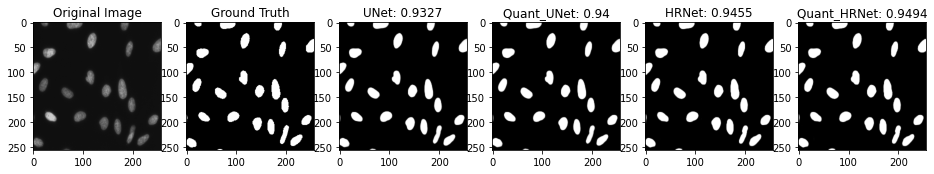

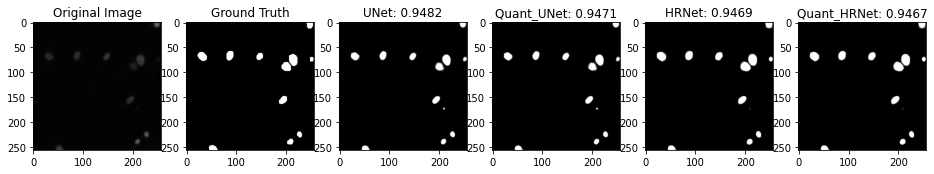

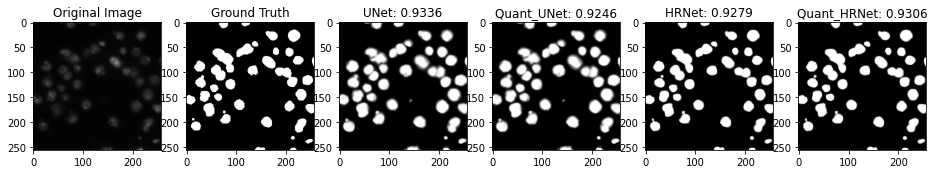

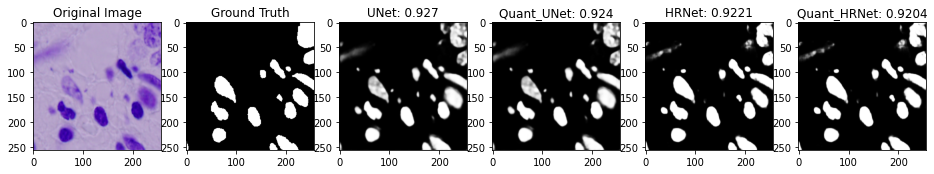

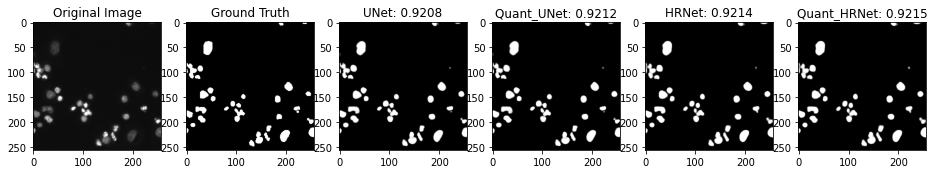

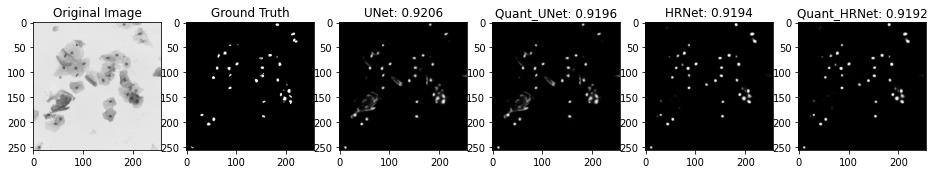

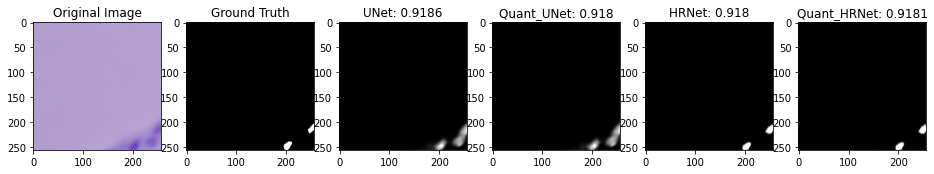

In [32]:
df = train.sample(n=8, random_state=1)
m = MeanIoU(2, 0.4)
for i in range(len(df)):
    image_path = df['images'].iloc[i]
    mask_path = df['masks'].iloc[i]
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
    mask_string = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask_string, channels=CLASSES)#
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])

    pred_mask_u = unet_model.predict(image[np.newaxis,:,:,:])
    m.update_state(mask, pred_mask_u)
    u_iou_score = m.result().numpy()

    pred_mask_qu = lite_unet_model(image[np.newaxis,:,:,:])[0]
    m.update_state(mask, pred_mask_qu)
    qu_iou_score = m.result().numpy()

    pred_mask_h = hrnet_model.predict(image[np.newaxis,:,:,:])
    m.update_state(mask, pred_mask_h)
    h_iou_score = m.result().numpy()

    pred_mask_qh = lite_hrnet_model(image[np.newaxis,:,:,:])[0]
    m.update_state(mask, pred_mask_qh)
    qh_iou_score = m.result().numpy()

    fig = plt.figure(figsize=(16,14))

    ax1 = fig.add_subplot(161)
    ax1.title.set_text('Original Image')    
    ax1.imshow(image)

    ax2 = fig.add_subplot(162)
    ax2.title.set_text('Ground Truth')    
    ax2.imshow(mask[:,:,0], cmap='gray')

    ax3 = fig.add_subplot(163)
    ax3.title.set_text('UNet: '+ str(round(u_iou_score,4)))    
    ax3.imshow(pred_mask_u[0,:,:,0], cmap='gray')

    ax4 = fig.add_subplot(164)
    ax4.title.set_text('Quant_UNet: '+ str(round(qu_iou_score,4)))    
    ax4.imshow(pred_mask_qu[:,:,0], cmap='gray')

    ax5 = fig.add_subplot(165)
    ax5.title.set_text('HRNet: '+ str(round(h_iou_score,4)))    
    ax5.imshow(pred_mask_h[0,:,:,0], cmap='gray')

    ax6 = fig.add_subplot(166)
    ax6.title.set_text('Quant_HRNet: '+ str(round(qh_iou_score,4)))    
    ax6.imshow(pred_mask_qh[:,:,0], cmap='gray')
    
    plt.show()

- For some points UNet is performing better than HRNet and for some HRNet is performing better than UNet.
- Also it can be seen that for those data points where UNet performed better than HRNet, their quantized version shows the same behaviour.
- Overall, there are very small differences in the IoU scores of all the four models.

# Average IoU scores over a sample of 30 images.

In [33]:
df = train.sample(n=30, random_state=1)
unet_iou_scores = []
quant_unet_iou_scores = []
hrnet_iou_scores = []
quant_hrnet_iou_scores = []
m = MeanIoU(2, 0.4)
for i in range(len(df)):
    image_path = df['images'].iloc[i]
    mask_path = df['masks'].iloc[i]
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
    mask_string = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask_string, channels=CLASSES)#
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])

    pred_mask_u = unet_model.predict(image[np.newaxis,:,:,:])
    m.update_state(mask, pred_mask_u)
    u_iou_score = m.result().numpy()
    unet_iou_scores.append(round(u_iou_score,4))

    pred_mask_qu = lite_unet_model(image[np.newaxis,:,:,:])[0]
    m.update_state(mask, pred_mask_qu)
    qu_iou_score = m.result().numpy()
    quant_unet_iou_scores.append(round(qu_iou_score,4))

    pred_mask_h = hrnet_model.predict(image[np.newaxis,:,:,:])
    m.update_state(mask, pred_mask_h)
    h_iou_score = m.result().numpy()
    hrnet_iou_scores.append(round(h_iou_score,4))

    pred_mask_qh = lite_hrnet_model(image[np.newaxis,:,:,:])[0]
    m.update_state(mask, pred_mask_qh)
    qh_iou_score = m.result().numpy()
    quant_hrnet_iou_scores.append(round(qh_iou_score,4))

print('The average IoU Score for UNet model: ', np.mean(np.array(unet_iou_scores)))
print('The average IoU Score for Quantized UNet model: ', np.mean(np.array(quant_unet_iou_scores)))
print('The average IoU Score for HRNet model: ', np.mean(np.array(hrnet_iou_scores)))
print('The average IoU Score for Quantized HRNet model: ', np.mean(np.array(quant_hrnet_iou_scores)))

The average IoU Score for UNet model:  0.92931664
The average IoU Score for Quantized UNet model:  0.92901325
The average IoU Score for HRNet model:  0.93064
The average IoU Score for Quantized HRNet model:  0.9316934


- We can conclude that among UNet and HRNet, HRNet have better average IoU score.
- Similarly after quantization HRNet has better average IoU score.
- Also for this sample size quantized HRNet has better avergae IoU score than float HRNet.
- If we want to deploy model on smaller devices then quantized HRNet will be a better option.